# Optimización de Campañas de Marketing

## 1. Procesamiento de Datos

### Importación de librerías necesarias

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings("ignore", category=FutureWarning)

### Importar Dataset

In [2]:
df = pd.read_csv("marketing_campaign.csv", sep=";")

In [3]:
print("Dimensión del dataset:", df.shape)

Dimensión del dataset: (2240, 29)


### Creación de nuevas variables y tratamiento de las actuales

**Nivel de educación en niveles: High, Middle y Low**

In [3]:
def education_level(education):
    if education in ['Graduation', 'PhD', 'Master']:
        return 'High'
    elif education in ['Basic']:
        return 'Middle'
    else:
        return 'Low'

df['Education_Level'] = df['Education'].apply(education_level)

**Viviendo solo (Living Alone) o en compañía (Living with others)**

In [4]:
def living_status(marital_status):
    if marital_status in ['Alone', 'Absurd', 'YOLO']:
        return 'Living Alone'
    else:
        return 'Living with Others'

df['Living_Status'] = df['Marital_Status'].apply(living_status)

**Traspasar de año de nacimiento a edad**

In [5]:
df['Age'] = 2022 - df['Year_Birth']

**Sumar la cantidad de campañas previamente aceptadas**

In [6]:
df['Total_Campaigns_Accepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

**Sumar la cantidad total de dinero gastado**

In [7]:
df['Total_Spent'] = df['MntWines']+df["MntWines"] +df['MntFruits']+ df['MntMeatProducts'] +df['MntFishProducts']+df['MntSweetProducts']+ df['MntGoldProds']

**Variable dummy de si el cliente es padre o no**

In [8]:
df['Is_Parent'] = (df['Kidhome'] + df['Teenhome'] > 0).astype(int)

**Promedio de visitas mensuales del cliente a la página web de la compañía y radio online de compras online** 

In [9]:
df['avg_web_visits'] = round((df['NumWebVisitsMonth'] / 12), 2)

df['online_purchase_ratio'] = round((df['NumWebPurchases'] / (df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'])), 2)

### Tratamiento de datos nulos y duplicados

In [10]:
df = df.dropna()

In [11]:
df.duplicated().sum()

0

### Tratamiento de variables cualitativas

In [12]:
df = pd.get_dummies(df, columns=["Education_Level","Living_Status"])

In [13]:
df["Education_Level_High"] = df["Education_Level_High"].astype(int)
df["Education_Level_Low"] = df["Education_Level_Low"].astype(int)
df["Education_Level_Middle"] = df["Education_Level_Middle"].astype(int)
df["Living_Status_Living Alone"] = df["Living_Status_Living Alone"].astype(int)
df["Living_Status_Living with Others"] = df["Living_Status_Living with Others"].astype(int)

### Eliminamos columnas irrelevantes

In [14]:
to_drop = ['Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID','Education','Marital_Status', 'Kidhome', 'Teenhome']
df = df.drop(to_drop, axis=1)

### Tratamiento de ouliers con LOF

Detectamos y eliminamos outliers con LOF

In [15]:
lof = LocalOutlierFactor(n_neighbors=10, metric='euclidean')
labels = lof.fit_predict(df)
scores = lof.negative_outlier_factor_

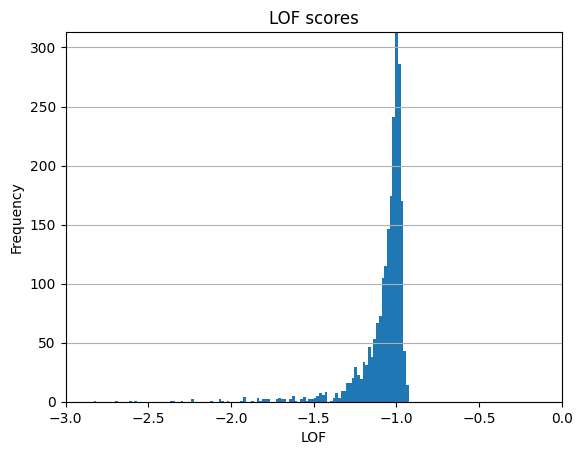

In [16]:
def plot_hist(X, title):
    x, bins, patches = plt.hist(x=X, bins='auto')
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))
    plt.xlim(-3, 0)

plot_hist(scores, 'LOF scores')

Usamos -1.5 como umbral de corte

In [17]:
def lof_threshold(v,scores):
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold, points

threshold, outliers = lof_threshold(-1.5,scores)
print(f'Datos bajo el umbral de corte: {threshold}')
print(f'Cantidad de outliers: {len(outliers)}')

Datos bajo el umbral de corte: 0.03484162895927602
Cantidad de outliers: 77


In [18]:
# Recuperado de clase
lof = LocalOutlierFactor(n_neighbors=10, metric='euclidean', contamination=threshold)
labels = lof.fit_predict(df)
indices = list(np.where(labels==1)[0])

dataset_limpio = df.iloc[indices]

print(dataset_limpio.shape)
print(dataset_limpio.head())

(2133, 31)
    Income  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  58138.0       58       635         88              546              172   
1  46344.0       38        11          1                6                2   
2  71613.0       26       426         49              127              111   
3  26646.0       26        11          4               20               10   
4  58293.0       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  ...  \
0                88            88                  3                8  ...   
1                 1             6                  2                1  ...   
2                21            42                  1                8  ...   
3                 3             5                  2                2  ...   
4                27            15                  5                5  ...   

   Total_Campaigns_Accepted  Total_Spent  Is_Parent

Vemos que, luego de limpiar los datos, quedamos con 2133 clientes y 33 características

### Estandarizamos los datos 

Estandarizamos los datos con StandardScaler (para las columnas no dummies)y guardamos datos de medias y desviaciones estándares relevantes.

In [19]:
column_means = {}
column_stddevs = {}

for column in dataset_limpio.columns:
    column_means[column] = dataset_limpio[column].mean()
    column_stddevs[column] = dataset_limpio[column].std()

In [20]:
scaler = StandardScaler()

num_cols = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
            'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
            'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
            'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
            'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
            'Age', 'Total_Campaigns_Accepted',
            'Total_Spent', 'avg_web_visits', 'online_purchase_ratio']

dataset_limpio.loc[:, num_cols] = scaler.fit_transform(dataset_limpio[num_cols])

### Balance de clases

Porcentaje de Response 1: 14.861697140178155
Porcentaje de Response 0: 85.13830285982185


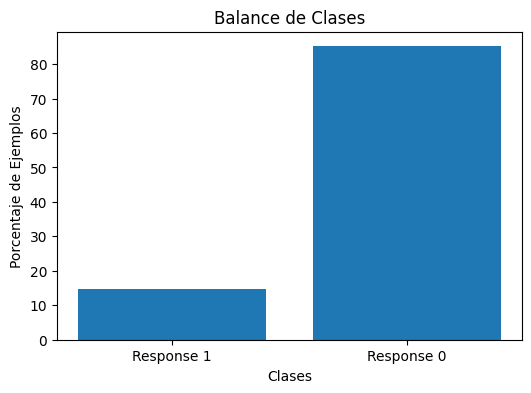

In [21]:
response_counts = dataset_limpio['Response'].value_counts()
total_samples = len(dataset_limpio)
percentage_response_1 = (response_counts[1] / total_samples) * 100
percentage_response_0 = (response_counts[0] / total_samples) * 100

print("Porcentaje de Response 1:", percentage_response_1)
print("Porcentaje de Response 0:", percentage_response_0)

# Visualizar el balance de clases
plt.figure(figsize=(6, 4))
plt.bar(['Response 1', 'Response 0'], [percentage_response_1, percentage_response_0])
plt.xlabel('Clases')
plt.ylabel('Porcentaje de Ejemplos')
plt.title('Balance de Clases')
plt.show()

## 2. Clustering

Realizamos clustering con PCA y KMEANS para identificar segmentos de clientes

In [22]:
df_clustering = dataset_limpio[["Education_Level_High", "Education_Level_Low", "Education_Level_Middle",
                    "Living_Status_Living Alone","Living_Status_Living with Others",'Age',"Is_Parent", "Income"]]

### PCA

In [23]:
pca = PCA(n_components=8)
pca.fit_transform(df_clustering)

array([[ 9.81107689e-01,  3.93852184e-01,  3.00205983e-01, ...,
        -3.24496073e-03,  7.57352554e-14,  3.19159071e-17],
       [ 5.89706098e-01,  1.15158169e+00, -1.61723795e-01, ...,
        -2.54672723e-03,  4.75096897e-15,  7.41162803e-18],
       [ 1.01854256e+00, -5.25059449e-01,  1.98684010e-01, ...,
        -4.96522294e-03, -9.83309894e-17, -1.31885732e-16],
       ...,
       [-3.95829526e-01, -1.04940238e+00,  1.62748829e-01, ...,
        -7.64226437e-03, -6.56451869e-17, -2.34569714e-17],
       [ 1.29860413e+00,  3.04874654e-01, -2.65600036e-01, ...,
        -3.33542248e-03,  2.21218561e-17,  2.15197058e-18],
       [ 8.23396226e-01,  9.45471858e-01, -1.87946312e-01, ...,
        -2.66653211e-03, -1.12486441e-17, -4.63003691e-18]])

In [24]:
# Código rescatado de clase.
def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

## Calculamos las componentes para retener el 95% de la varianza del dataset original
print(min_var(0.95, pca.explained_variance_ratio_))

4


In [25]:
pca_reducido = PCA(n_components=4)
X_Reducido_Cluster = pca_reducido.fit_transform(df_clustering)
list_k = list(range(2, 10))
silhouette_scores = []
for k in list_k:
    km = KMeans(n_clusters=k)
    preds = km.fit_predict(X_Reducido_Cluster)
    silhouette_scores.append(silhouette_score(X_Reducido_Cluster, preds))

best_k = list_k[np.argmax(silhouette_scores)]
best_k
silhouette_scores

[0.32721007950772335,
 0.3421658282825325,
 0.3071097354492918,
 0.31134266583984976,
 0.299849534691824,
 0.3128757500053762,
 0.30918492254573077,
 0.31037335410548206]

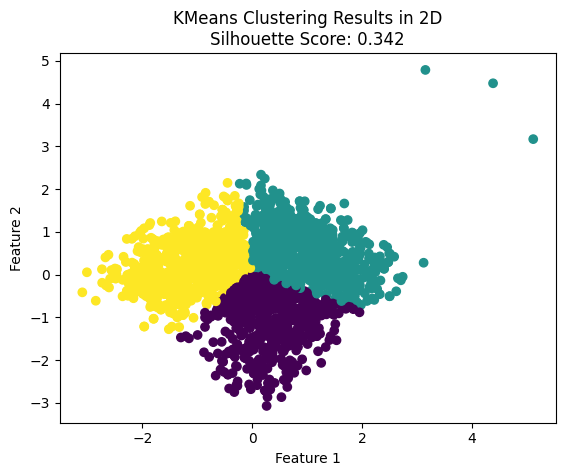

In [26]:
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(X_Reducido_Cluster)

predictions = kmeans.predict(X_Reducido_Cluster)

silhouette_score_value = silhouette_score(X_Reducido_Cluster, predictions)

plt.scatter(X_Reducido_Cluster[:, 0], X_Reducido_Cluster[:, 1], c=predictions, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering Results in 2D\nSilhouette Score: {0:.3f}'.format(silhouette_score_value))
plt.show()

Creamos una nueva columna en el dataset con los clusters detectados

In [27]:
df_clustering['segmentacion_cliente'] = predictions
df_clustering.head()

C:\Users\U\AppData\Local\Temp\ipykernel_7388\4184206296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering['segmentacion_cliente'] = predictions


,Education_Level_High,Education_Level_Low,Education_Level_Middle,Living_Status_Living Alone,Living_Status_Living with Others,Age,Is_Parent,Income,segmentacion_cliente
0,1,0,0,0,1,0.983636,0,0.295770,1
1,1,0,0,0,1,1.233518,1,-0.284885,1
2,1,0,0,0,1,0.317283,0,0.959186,0
3,1,0,0,0,1,-1.265305,1,-1.254678,2
4,1,0,0,0,1,-1.015423,1,0.303401,0


In [28]:
df_clustering.loc[:, 'Age'] = df_clustering['Age'] * column_stddevs['Age'] + column_means['Age']
df_clustering.loc[:, 'Income'] = df_clustering['Income'] * column_stddevs['Income'] + column_means['Income']

In [30]:
print(df_clustering.columns)

Index(['Education_Level_High', 'Education_Level_Low', 'Education_Level_Middle',
       'Living_Status_Living Alone', 'Living_Status_Living with Others', 'Age',
       'Is_Parent', 'Income', 'segmentacion_cliente'],
      dtype='object')


**Análisis por Ingreso (Income)**

                      count          mean           std           min  \
segmentacion_cliente                                                    
0                     585.0  70589.638667  10788.672698  48788.216450   
1                     720.0  59904.693420  14821.415720  15024.300868   
2                     828.0  32328.418016  10253.978530   7489.534424   

                               25%           50%           75%           max  
segmentacion_cliente                                                          
0                     61907.292074  70341.269328  78937.284571  96886.492567  
1                     49464.124909  59641.760945  70841.136517  94651.968707  
2                     24462.013437  33034.523168  40555.786446  52413.066257  


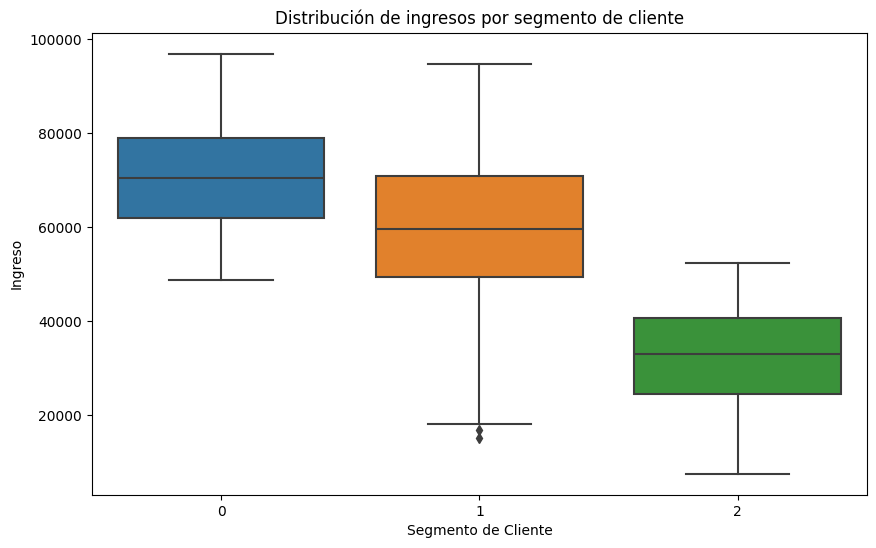

In [29]:
resumen_por_segmento_ingresos = df_clustering.groupby('segmentacion_cliente')['Income'].describe()
print(resumen_por_segmento_ingresos)

plt.figure(figsize=(10, 6))
sns.boxplot(x='segmentacion_cliente', y='Income', data=df_clustering)
plt.title('Distribución de ingresos por segmento de cliente')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Ingreso')
plt.show()

**Análisis por Edad (Age)**

                      count          mean           std           min  \
segmentacion_cliente                                                    
0                     828.0  32328.418016  10253.978530   7489.534424   
1                     721.0  59899.215200  14811.849936  15024.300868   
2                     584.0  70614.698157  10780.867797  48788.216450   

                               25%           50%           75%           max  
segmentacion_cliente                                                          
0                     24462.013437  33034.523168  40555.786446  52413.066257  
1                     49475.377547  59595.750159  70796.376023  94651.968707  
2                     61916.294185  70362.274253  78990.296999  96886.492567  


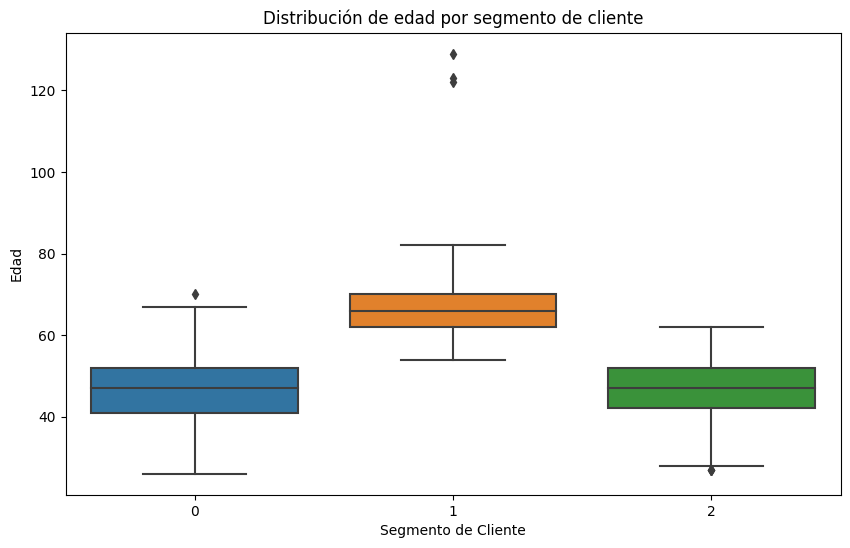

In [32]:
resumen_por_segmento_edad = df_clustering.groupby('segmentacion_cliente')['Age'].describe()
print(resumen_por_segmento_ingresos)

plt.figure(figsize=(10, 6))
sns.boxplot(x='segmentacion_cliente', y='Age', data=df_clustering)
plt.title('Distribución de edad por segmento de cliente')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Edad')
plt.show()

**Análisis si es padre/madre**

Porcentaje de padres por segmento:
segmentacion_cliente
0    88.888889
1    70.457698
2    50.171233
Name: Is_Parent, dtype: float64


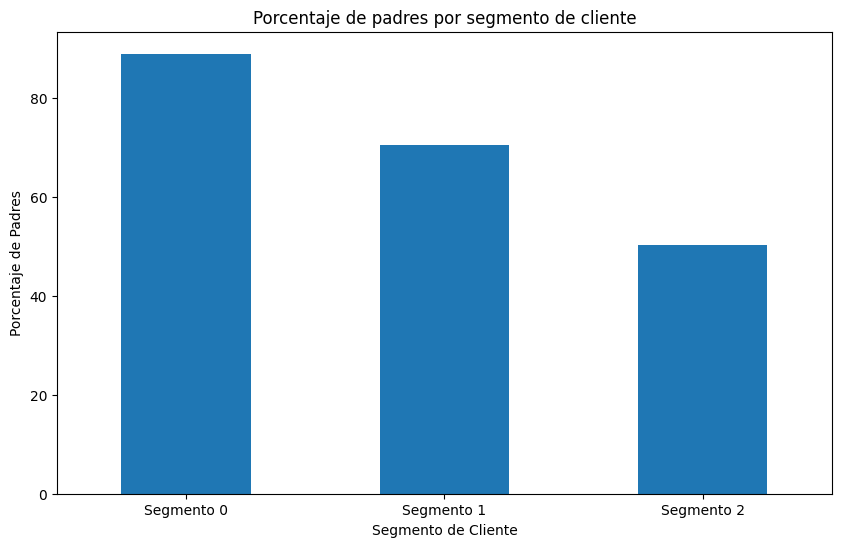

In [33]:
parent_percentage_by_segment = df_clustering.groupby('segmentacion_cliente')['Is_Parent'].mean() * 100

print("Porcentaje de padres por segmento:")
print(parent_percentage_by_segment)

plt.figure(figsize=(10, 6))
parent_percentage_by_segment.plot(kind='bar')
plt.title('Porcentaje de padres por segmento de cliente')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Porcentaje de Padres')
plt.xticks(ticks=[0, 1, 2], labels=['Segmento 0', 'Segmento 1', 'Segmento 2'], rotation=0)
plt.show()


**Análisis por Educación**

Porcentaje de niveles de educación por segmento:
                      Education_Level_High  Education_Level_Middle  \
segmentacion_cliente                                                 
0                                81.642512                6.038647   
1                                93.758669                0.138696   
2                                91.609589                0.000000   

                      Education_Level_Low  
segmentacion_cliente                       
0                               12.318841  
1                                6.102635  
2                                8.390411  


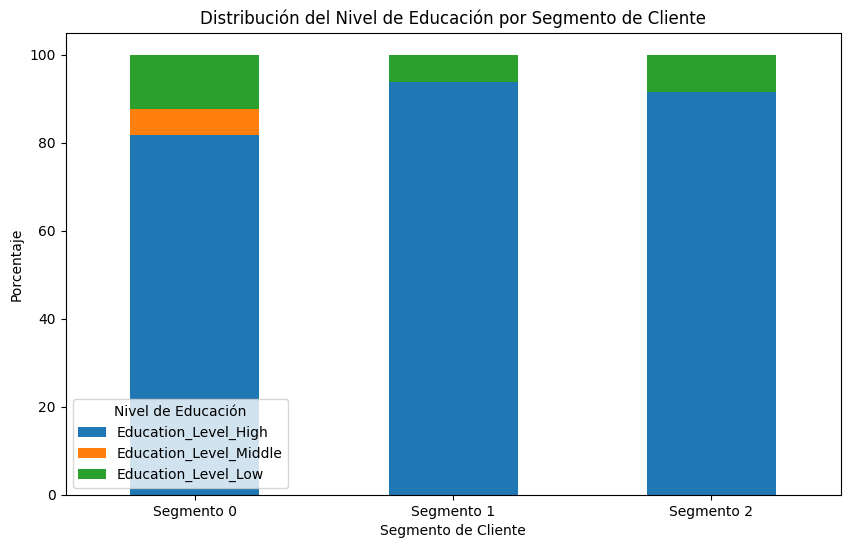

In [34]:
# Calcular el porcentaje de los niveles de educación por segmento
education_levels = ['Education_Level_High', 'Education_Level_Middle', 'Education_Level_Low']
education_percentage_by_segment = df_clustering.groupby('segmentacion_cliente')[education_levels].mean() * 100

print("Porcentaje de niveles de educación por segmento:")
print(education_percentage_by_segment)

# Crear un gráfico de barras apiladas para visualizar el porcentaje de niveles de educación por segmento
education_percentage_by_segment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución del Nivel de Educación por Segmento de Cliente')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Porcentaje')
plt.xticks(ticks=[0, 1, 2], labels=['Segmento 0', 'Segmento 1', 'Segmento 2'], rotation=0)
plt.legend(title='Nivel de Educación')
plt.show()


**Análisis por convivencia**

Porcentaje de convivencia por segmento:
                      Living_Status_Living Alone  \
segmentacion_cliente                               
0                                       0.483092   
1                                       0.277393   
2                                       0.171233   

                      Living_Status_Living with Others  
segmentacion_cliente                                    
0                                            99.516908  
1                                            99.722607  
2                                            99.828767  


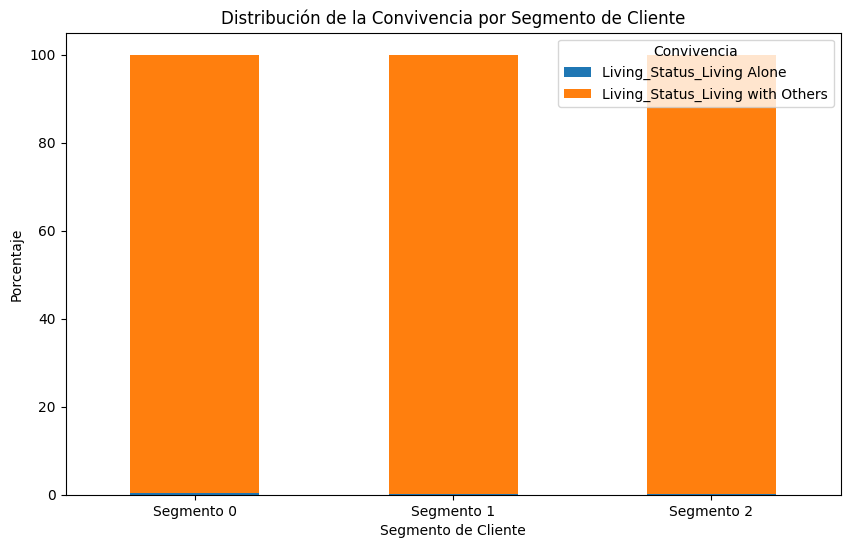

In [35]:
# Calcular el porcentaje de la convivencia por segmento
living_status = ['Living_Status_Living Alone', 'Living_Status_Living with Others']
living_percentage_by_segment = df_clustering.groupby('segmentacion_cliente')[living_status].mean() * 100

print("Porcentaje de convivencia por segmento:")
print(living_percentage_by_segment)

# Crear un gráfico de barras apiladas para visualizar el porcentaje de convivencia por segmento
living_percentage_by_segment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribución de la Convivencia por Segmento de Cliente')
plt.xlabel('Segmento de Cliente')
plt.ylabel('Porcentaje')
plt.xticks(ticks=[0, 1, 2], labels=['Segmento 0', 'Segmento 1', 'Segmento 2'], rotation=0)
plt.legend(title='Convivencia')
plt.show()


In [36]:
#TODO Ver una manera más grafica de mostrar esto y resumirlo

## 3. MLP

### Adaptación del dataset

In [30]:
df_mlp = dataset_limpio.copy()
df_mlp['segmentacion_cliente'] = predictions
dfl_mlp = df_mlp.drop(["Education_Level_High", "Education_Level_Low", "Education_Level_Middle",
                    "Living_Status_Living Alone","Living_Status_Living with Others",'Age',"Is_Parent", "Income"], axis=1)
dfl_mlp = pd.get_dummies(dfl_mlp, columns=["segmentacion_cliente"])
dfl_mlp["segmentacion_cliente_0"] = dfl_mlp["segmentacion_cliente_0"].astype(int)
dfl_mlp["segmentacion_cliente_1"] = dfl_mlp["segmentacion_cliente_1"].astype(int)
dfl_mlp["segmentacion_cliente_2"] = dfl_mlp["segmentacion_cliente_2"].astype(int)

### Partición training y test

In [38]:
X = dfl_mlp.drop(columns=['Response'])
y = dfl_mlp['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 1493
Tamaño del conjunto de prueba: 640


In [39]:
# def construir_modelo_model(input_shape, capas1, capas2):
#     inputs = Input(shape = input_shape)
#     dense1 = Dense(capas1, activation="relu")
#     dense2 = Dense(capas2, activation="relu")
#     dense3 = Dense(1, activation="sigmoid")
#     x = dense1(inputs)
#     x = dense2(x)
#     outputs = dense3(x)
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# def construir_modelo_sequential(input_shape, capas1, capas2):
#     model = Sequential()
#     model.add(Dense(capas1, activation="relu", input_shape = input_shape))
#     model.add(Dense(capas2, activation="relu"))
#     model.add(Dense(1, activation="sigmoid"))
#     return model

def create_model_model(input_shape, capas1, capas2):
    inputs = Input(shape=input_shape)
    x = Dense(capas1, activation="relu")(inputs)
    x = Dense(capas2, activation="relu")(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_model_sequential(input_shape, capas1, capas2):
    model = Sequential()
    model.add(Dense(capas1, activation="relu", input_shape=input_shape))
    model.add(Dense(capas2, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [40]:
param_grid = {
    'model__capas1': [50, 100, 150], 
    'model__capas2': [20, 50, 100], 
    'batch_size': [10, 20, 50],  
    'epochs': [10, 50, 100]
}


model_model = KerasClassifier(model=create_model_model, input_shape=(X_train.shape[1],), verbose=0)
model_sequential = KerasClassifier(model=create_model_sequential, input_shape=(X_train.shape[1],), verbose=0)

grid_model = GridSearchCV(estimator=model_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_sequential = GridSearchCV(estimator=model_sequential, param_grid=param_grid, n_jobs=-1, cv=3)


grid_model_result = grid_model.fit(X_train, y_train)
grid_sequential_result = grid_sequential.fit(X_train, y_train)

print("Best Parameters for model model:", grid_model_result.best_params_)
print("Best Accuracy for model model:", grid_model_result.best_score_)

print("Best Parameters for sequential model:", grid_sequential_result.best_params_)
print("Best Accuracy for sequential model:", grid_sequential_result.best_score_)

C:\Users\U\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for model model: {'batch_size': 10, 'epochs': 10, 'model__capas1': 50, 'model__capas2': 100}
Best Accuracy for model model: 0.884111900317568
Best Parameters for sequential model: {'batch_size': 20, 'epochs': 10, 'model__capas1': 150, 'model__capas2': 100}
Best Accuracy for sequential model: 0.8834371691999386


In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

def evaluar_modelo(model: Sequential, X_test: pd.DataFrame, y_test: pd.Series):

    y_pred = model.predict(X_test)

    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]

    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))

    return y_pred_binary

y_pred_binary_model = evaluar_modelo(grid_model_result, X_test, y_test)
y_pred_binary_sequential = evaluar_modelo(grid_sequential_result, X_test, y_test)


Accuracy: 0.8797
Precision: 0.6596
Recall: 0.3370
F1-score: 0.4460

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       548
           1       0.66      0.34      0.45        92

    accuracy                           0.88       640
   macro avg       0.78      0.65      0.69       640
weighted avg       0.86      0.88      0.86       640

Accuracy: 0.8875
Precision: 0.6852
Recall: 0.4022
F1-score: 0.5068

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       548
           1       0.69      0.40      0.51        92

    accuracy                           0.89       640
   macro avg       0.80      0.69      0.72       640
weighted avg       0.87      0.89      0.87       640



## 4. Regresión Logística

### Con el mismo df que MLP

In [31]:
df_regresion = dfl_mlp.copy()

### Dividimos el dataset para cada uno de los clusters

In [41]:
df_regresion.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp2,Complain,Response,Total_Campaigns_Accepted,Total_Spent,avg_web_visits,online_purchase_ratio,segmentacion_cliente_0,segmentacion_cliente_1,segmentacion_cliente_2
0,0.312911,0.977323,1.539145,1.749007,2.453021,1.499843,0.879225,0.409245,1.512997,2.676257,...,-0.113228,0,1,-0.439215,1.457658,0.755324,0.286046,0,1,0
1,-0.377805,-0.879167,-0.640118,-0.738339,-0.652556,-0.638472,-0.737607,-0.150678,-1.167739,-0.597358,...,-0.113228,0,0,-0.439215,-0.954272,-0.091290,-0.678110,0,1,0
2,-0.792234,0.355518,0.562234,-0.180989,1.338667,-0.146905,-0.027778,-0.710601,1.512997,-0.233623,...,-0.113228,0,0,-0.439215,0.313788,-0.567510,0.636648,1,0,0
3,-0.792234,-0.879167,-0.564971,-0.673852,-0.506411,-0.589315,-0.757324,-0.150678,-0.784776,-0.961093,...,-0.113228,0,0,-0.439215,-0.925948,0.332017,0.023094,0,0,1
4,1.556198,-0.397193,0.411940,-0.222445,0.151241,0.000565,-0.560149,1.529091,0.364110,0.130112,...,-0.113228,0,0,-0.439215,-0.347477,-0.091290,0.286046,1,0,0


In [42]:
df_regresion_0 = df_regresion[df_regresion['segmentacion_cliente_0'] == 1]
df_regresion_1 = df_regresion[df_regresion['segmentacion_cliente_1'] == 1]
df_regresion_2 = df_regresion[df_regresion['segmentacion_cliente_2'] == 1]

In [45]:
lista_df = [df_regresion_0, df_regresion_1, df_regresion_2]

### Partición train y test

In [74]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.linear_model import LogisticRegression

In [75]:
def crear_evaluar_modelo(df):
    X = df.drop(columns=['Response'])
    y = df['Response']
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # print("Tamaño del conjunto de entrenamiento:", len(X_train))
    # print("Tamaño del conjunto de prueba:", len(X_test))

    # Aplicar SMOTE solo al conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Verificar los porcentajes después del sobremuestreo
    response_counts_resampled =  pd.Series(y_train).value_counts()
    total_samples_resampled = len(y_train)
    percentage_response_0_resampled = (response_counts_resampled[1] / total_samples_resampled) * 100
    percentage_response_1_resampled = (response_counts_resampled[0] / total_samples_resampled) * 100

    print("Porcentaje de Response 1 después del sobremuestreo:", percentage_response_1_resampled)
    print("Porcentaje de Response 0 después del sobremuestreo:", percentage_response_0_resampled)

    # Visualizar el balance de clases
    plt.figure(figsize=(6, 4))
    plt.bar(['Response 1', 'Response 0'], [percentage_response_1_resampled, percentage_response_0_resampled])
    plt.xlabel('Clases')
    plt.ylabel('Porcentaje de Ejemplos')
    plt.title('Balance de Clases')
    plt.show()

    print("Tamaño del conjunto de entrenamiento:", len(X_train))
    print("Tamaño del conjunto de prueba:", len(X_test))

    # Creamos modelo
    model = LogisticRegression()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)

    param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'max_iter': [100, 200, 300]
    }

    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Mejores parámetros:", best_params)
    print("Mejor puntuación en entrenamiento:", best_score)

    # Una vez que encuentres los mejores parámetros, puedes usarlos para entrenar el modelo final
    best_clf = LogisticRegression(**best_params)
    best_clf.fit(X_train, y_train)
    test_score = best_clf.score(X_test, y_test)
    print("Puntuación en el conjunto de prueba:", test_score)

    # Evaluamos
    y_pred = best_clf.predict(X_test)

    # Evaluar rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_result = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Imprimir resultados
    print("Accuracy:", accuracy)
    print("\nClassification Report: \n", classification_report_result)
    print("\nConfusion Matrix: \n", conf_matrix)
    print("-"*100)
    print("")

Porcentaje de Response 1 después del sobremuestreo: 50.0
Porcentaje de Response 0 después del sobremuestreo: 50.0


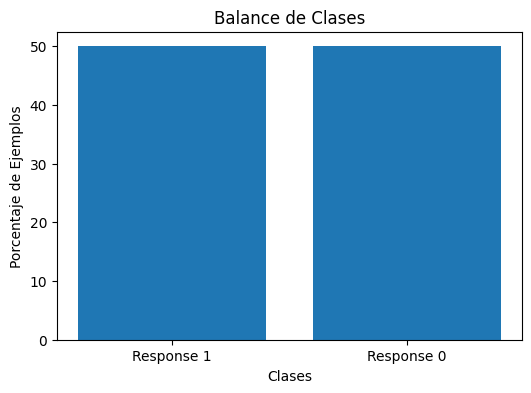

Tamaño del conjunto de entrenamiento: 742
Tamaño del conjunto de prueba: 186


C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\P

Mejores parámetros: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación en entrenamiento: 0.8073009250861599
Puntuación en el conjunto de prueba: 0.8010752688172043
Accuracy: 0.8010752688172043

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.74      0.79        93
           1       0.77      0.86      0.81        93

    accuracy                           0.80       186
   macro avg       0.81      0.80      0.80       186
weighted avg       0.81      0.80      0.80       186


Confusion Matrix: 
 [[69 24]
 [13 80]]
----------------------------------------------------------------------------------------------------

Porcentaje de Response 1 después del sobremuestreo: 49.29435483870967
Porcentaje de Response 0 después del sobremuestreo: 50.70564516129033


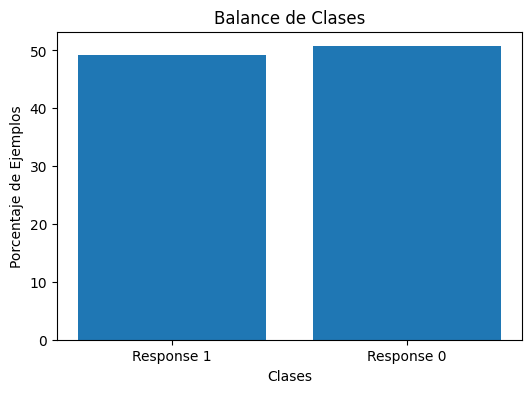

Tamaño del conjunto de entrenamiento: 992
Tamaño del conjunto de prueba: 248


C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\P

Mejores parámetros: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor puntuación en entrenamiento: 0.829653317090503
Puntuación en el conjunto de prueba: 0.8225806451612904
Accuracy: 0.8225806451612904

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.79      0.82       131
           1       0.78      0.86      0.82       117

    accuracy                           0.82       248
   macro avg       0.82      0.82      0.82       248
weighted avg       0.83      0.82      0.82       248


Confusion Matrix: 
 [[103  28]
 [ 16 101]]
----------------------------------------------------------------------------------------------------

Porcentaje de Response 1 después del sobremuestreo: 49.87190435525192
Porcentaje de Response 0 después del sobremuestreo: 50.128095644748086


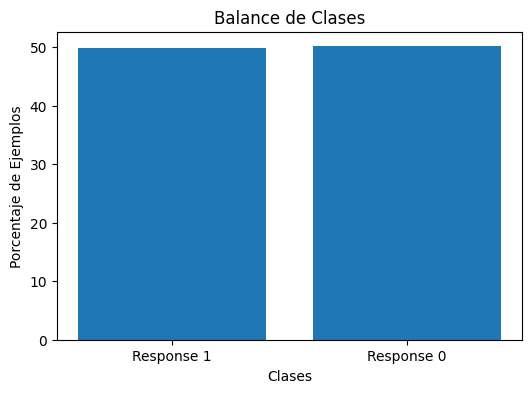

Tamaño del conjunto de entrenamiento: 1171
Tamaño del conjunto de prueba: 293


C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\P

Mejores parámetros: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor puntuación en entrenamiento: 0.8463138752500455
Puntuación en el conjunto de prueba: 0.863481228668942
Accuracy: 0.863481228668942

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       148
           1       0.84      0.89      0.87       145

    accuracy                           0.86       293
   macro avg       0.86      0.86      0.86       293
weighted avg       0.86      0.86      0.86       293


Confusion Matrix: 
 [[124  24]
 [ 16 129]]
----------------------------------------------------------------------------------------------------



In [76]:
for df in lista_df:
    crear_evaluar_modelo(df)

## SVM

In [66]:
from sklearn.svm import SVC

In [77]:
def crear_evaluar_modelo_SVM(df):
    X = df.drop(columns=['Response'])
    y = df['Response']
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # print("Tamaño del conjunto de entrenamiento:", len(X_train))
    # print("Tamaño del conjunto de prueba:", len(X_test))

    # Aplicar SMOTE solo al conjunto de entrenamiento
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Verificar los porcentajes después del sobremuestreo
    response_counts_resampled =  pd.Series(y_train).value_counts()
    total_samples_resampled = len(y_train)
    percentage_response_0_resampled = (response_counts_resampled[1] / total_samples_resampled) * 100
    percentage_response_1_resampled = (response_counts_resampled[0] / total_samples_resampled) * 100

    print("Porcentaje de Response 1 después del sobremuestreo:", percentage_response_1_resampled)
    print("Porcentaje de Response 0 después del sobremuestreo:", percentage_response_0_resampled)

    # Visualizar el balance de clases
    plt.figure(figsize=(6, 4))
    plt.bar(['Response 1', 'Response 0'], [percentage_response_1_resampled, percentage_response_0_resampled])
    plt.xlabel('Clases')
    plt.ylabel('Porcentaje de Ejemplos')
    plt.title('Balance de Clases')
    plt.show()

    print("Tamaño del conjunto de entrenamiento:", len(X_train))
    print("Tamaño del conjunto de prueba:", len(X_test))

    # Creamos modelo
    model = SVC()
    model.fit(X_train, y_train)
    model.score(X_test, y_test)

    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced', None]
    }

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Mejores parámetros:", best_params)
    print("Mejor puntuación en entrenamiento:", best_score)

    # Una vez que encuentres los mejores parámetros, puedes usarlos para entrenar el modelo final
    best_clf = SVC(**best_params)
    best_clf.fit(X_train, y_train)
    test_score = best_clf.score(X_test, y_test)
    print("\nPuntuación en el conjunto de prueba:", test_score)

    # Evaluamos
    y_pred = best_clf.predict(X_test)

    # Evaluar rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_result = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Imprimir resultados
    print("Accuracy:", accuracy)
    print("\nClassification Report: \n", classification_report_result)
    print("\nConfusion Matrix: \n", conf_matrix)
    print("-"*100)
    print("")

Porcentaje de Response 1 después del sobremuestreo: 50.0
Porcentaje de Response 0 después del sobremuestreo: 50.0


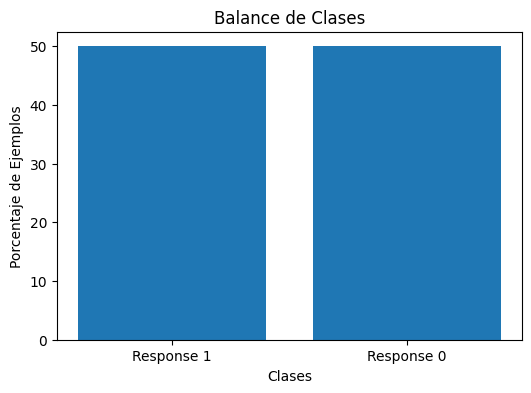

Tamaño del conjunto de entrenamiento: 742
Tamaño del conjunto de prueba: 186
Mejores parámetros: {'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Mejor puntuación en entrenamiento: 0.8988935243968801

Puntuación en el conjunto de prueba: 0.9086021505376344
Accuracy: 0.9086021505376344

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.89      0.91        93
           1       0.90      0.92      0.91        93

    accuracy                           0.91       186
   macro avg       0.91      0.91      0.91       186
weighted avg       0.91      0.91      0.91       186


Confusion Matrix: 
 [[83 10]
 [ 7 86]]
----------------------------------------------------------------------------------------------------

Porcentaje de Response 1 después del sobremuestreo: 49.29435483870967
Porcentaje de Response 0 después del sobremuestreo: 50.70564516129033


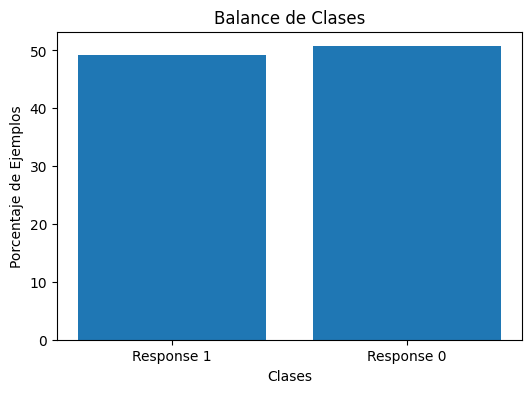

Tamaño del conjunto de entrenamiento: 992
Tamaño del conjunto de prueba: 248
Mejores parámetros: {'C': 10, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor puntuación en entrenamiento: 0.9213999289376174

Puntuación en el conjunto de prueba: 0.9233870967741935
Accuracy: 0.9233870967741935

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       131
           1       0.89      0.96      0.92       117

    accuracy                           0.92       248
   macro avg       0.92      0.93      0.92       248
weighted avg       0.93      0.92      0.92       248


Confusion Matrix: 
 [[117  14]
 [  5 112]]
----------------------------------------------------------------------------------------------------

Porcentaje de Response 1 después del sobremuestreo: 49.87190435525192
Porcentaje de Response 0 después del sobremuestreo: 50.128095644748086


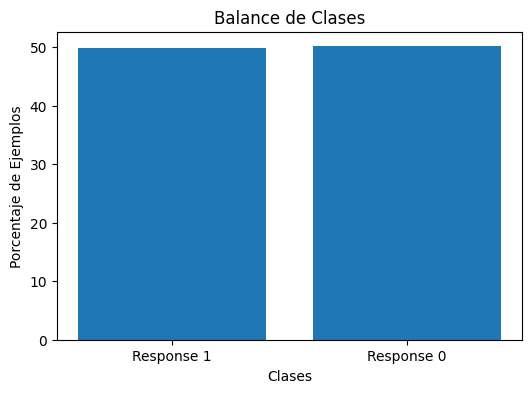

Tamaño del conjunto de entrenamiento: 1171
Tamaño del conjunto de prueba: 293
Mejores parámetros: {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuación en entrenamiento: 0.8889907255864703

Puntuación en el conjunto de prueba: 0.8839590443686007
Accuracy: 0.8839590443686007

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88       148
           1       0.87      0.90      0.89       145

    accuracy                           0.88       293
   macro avg       0.88      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293


Confusion Matrix: 
 [[128  20]
 [ 14 131]]
----------------------------------------------------------------------------------------------------



In [78]:
for df in lista_df:
    crear_evaluar_modelo_SVM(df)

In [32]:
X_regresion = df_regresion.drop(columns=['Response'])
y_regresion = df_regresion['Response']

X_train_regresion, X_test_regresion, y_train_regresion, y_test_regresion = train_test_split(X_regresion, y_regresion, test_size=0.3, random_state=42)

print("Tamaño del conjunto de entrenamiento:", len(X_train_regresion))
print("Tamaño del conjunto de prueba:", len(X_test_regresion))

Tamaño del conjunto de entrenamiento: 1493
Tamaño del conjunto de prueba: 640


## Nuevo

### Se realiza un oversampling para aumentar la cantidad de ejemplos en la clase minoritaria

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_regresion, y_train_regresion)

Porcentaje de Response 1 después del sobremuestreo: 50.0
Porcentaje de Response 0 después del sobremuestreo: 50.0


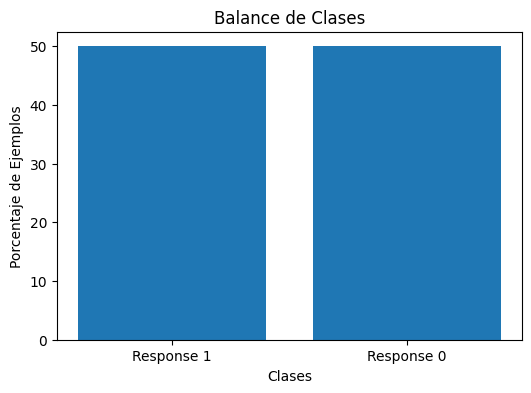

Tamaño del conjunto de entrenamiento: 2536
Tamaño del conjunto de prueba: 640


In [43]:
# Verificar los porcentajes después del sobremuestreo
response_counts_resampled =  pd.Series(y_train_resampled).value_counts()
total_samples_resampled = len(y_train_resampled)
percentage_response_0_resampled = (response_counts_resampled[1] / total_samples_resampled) * 100
percentage_response_1_resampled = (response_counts_resampled[0] / total_samples_resampled) * 100

print("Porcentaje de Response 1 después del sobremuestreo:", percentage_response_1_resampled)
print("Porcentaje de Response 0 después del sobremuestreo:", percentage_response_0_resampled)

# Visualizar el balance de clases
plt.figure(figsize=(6, 4))
plt.bar(['Response 1', 'Response 0'], [percentage_response_1_resampled, percentage_response_0_resampled])
plt.xlabel('Clases')
plt.ylabel('Porcentaje de Ejemplos')
plt.title('Balance de Clases')
plt.show()

print("Tamaño del conjunto de entrenamiento:", len(X_train_resampled))
print("Tamaño del conjunto de prueba:", len(X_test_regresion))

### Este modelo de Regresión Logística es usando oversampling

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)
model.score(X_test_regresion, y_test_regresion)

0.8234375

In [39]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros:", best_params)
print("Mejor puntuación en entrenamiento:", best_score)

# Una vez que encuentres los mejores parámetros, puedes usarlos para entrenar el modelo final
best_clf = LogisticRegression(**best_params)
best_clf.fit(X_train_resampled, y_train_resampled)
test_score = best_clf.score(X_test_regresion, y_test_regresion)
print("Puntuación en el conjunto de prueba:", test_score)

C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logis

Mejores parámetros: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación en entrenamiento: 0.8379482520306263
Puntuación en el conjunto de prueba: 0.825


C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
  

### Evaluamos

In [40]:
y_pred = best_clf.predict(X_test_regresion)

# Evaluar rendimiento del modelo
accuracy = accuracy_score(y_test_regresion, y_pred)
classification_report_result = classification_report(y_test_regresion, y_pred)
conf_matrix = confusion_matrix(y_test_regresion, y_pred)

# Imprimir resultados
print("Accuracy:", accuracy)
print("\nClassification Report: \n", classification_report_result)
print("\nConfusion Matrix: \n", conf_matrix)

Accuracy: 0.825

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.86      0.89       548
           1       0.43      0.63      0.51        92

    accuracy                           0.82       640
   macro avg       0.68      0.74      0.70       640
weighted avg       0.86      0.82      0.84       640


Confusion Matrix: 
 [[470  78]
 [ 34  58]]


## Antiguo

### Creamos modelo Regresión Logística

In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_regresion, y_train_regresion)
clf.score(X_test_regresion, y_test_regresion)

0.890625

In [46]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_regresion, y_train_regresion)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros:", best_params)
print("Mejor puntuación en entrenamiento:", best_score)

# Una vez que encuentres los mejores parámetros, puedes usarlos para entrenar el modelo final
best_clf = LogisticRegression(**best_params)
best_clf.fit(X_train_regresion, y_train_regresion)
test_score = best_clf.score(X_test_regresion, y_test_regresion)
print("Puntuación en el conjunto de prueba:", test_score)

C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\U\AppData\Roaming\Python\P

Mejores parámetros: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor puntuación en entrenamiento: 0.8847814863863886
Puntuación en el conjunto de prueba: 0.8875


### Evaluamos

In [47]:
y_pred_regresion = best_clf.predict(X_test_regresion)
print(f'Accuracy: {accuracy_score(y_test_regresion, y_pred_regresion)}')

print(classification_report(y_test_regresion, y_pred_regresion))

Accuracy: 0.8875
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       548
           1       0.75      0.33      0.45        92

    accuracy                           0.89       640
   macro avg       0.82      0.65      0.70       640
weighted avg       0.88      0.89      0.87       640

